# Обучение нейросетей — оптимизация и регуляризация

**Разработчик: Артем Бабенко**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mryab/dl-hse-ami/blob/master/week04_training/homework.ipynb)


На этом семинаре будет необходимо
1. реализовать Dropout-слой и проследить его влияние на обобщающую способность сети
2. реализовать BatchNormalization-слой и пронаблюдать его влияние на скорость сходимости обучения.

## Dropout

Как всегда будем экспериментировать на датасете MNIST. MNIST является стандартным бенчмарк-датасетом, и его можно подгрузить средствами pytorch.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/',
                                  train=False,
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 123963025.64it/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67749269.48it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40606234.27it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9154506.86it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Определим ряд стандартных функций с прошлых семинаров

In [3]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = x_batch
        target = y_batch

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        data = x_batch
        target = y_batch

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

        print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))


Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее с параметрами оптимизации, заданными ниже.

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim=-1)
    )

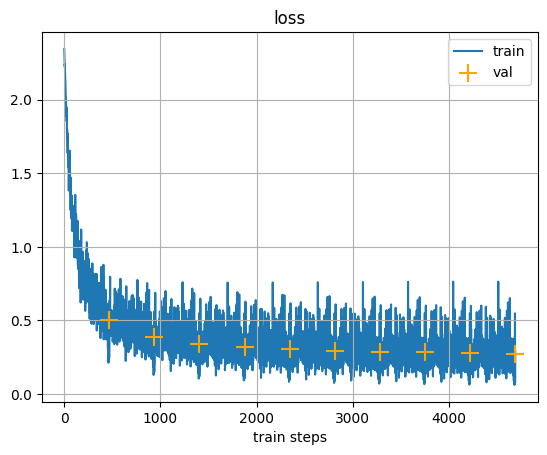

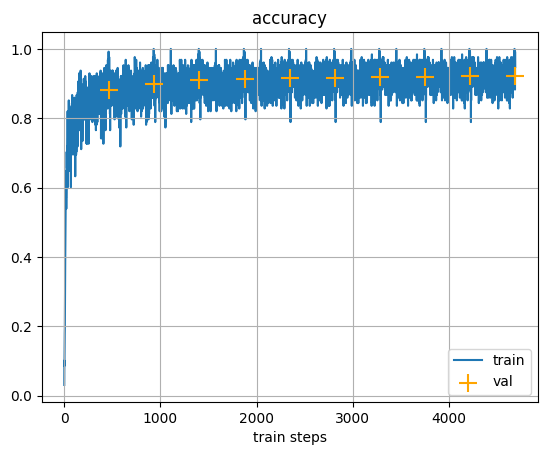

Epoch: 9, val loss: 0.27551562082069586, val accuracy: 0.923061728477478


In [5]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 10)

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Визуализируйте обученные векторы для каждого из классов, сделав их двумерными изображениями 28-28. Для визуализации можно воспользоваться кодом для визуализации MNIST-картинок с предыдущих семинаров.

In [6]:
model[1].weight.data.numpy()

array([[ 0.00991247,  0.00125585, -0.01380048, ..., -0.0079511 ,
        -0.01059003, -0.0177039 ],
       [-0.03257854, -0.03323798,  0.01686329, ..., -0.00811074,
        -0.00076651, -0.01476315],
       [-0.02686883, -0.02418995, -0.00182028, ..., -0.03391722,
         0.01357283, -0.006474  ],
       ...,
       [ 0.01908922, -0.00442112, -0.03072067, ...,  0.02020555,
         0.02349994, -0.03548701],
       [-0.02171851,  0.01870881,  0.0111167 , ...,  0.03022596,
         0.0083073 , -0.01168686],
       [-0.00437278, -0.01444198, -0.01645742, ..., -0.000961  ,
         0.00811225, -0.03487002]], dtype=float32)

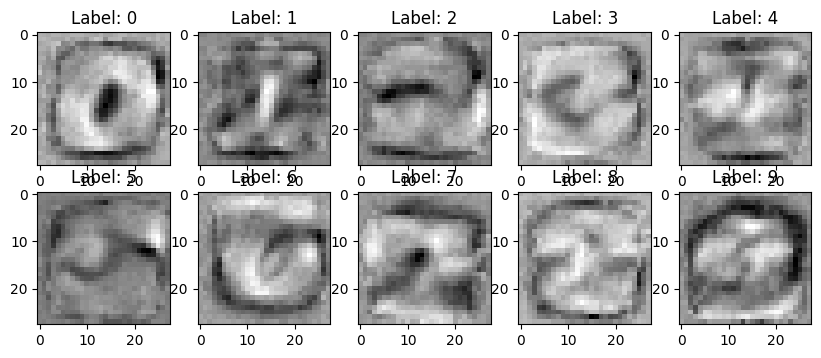

In [7]:
weights = model[1].weight.data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Реализуйте Dropout-слой для полносвязной сети. Помните, что этот слой ведет себя по-разному во время обучения и во время применения.

In [8]:
from torch.autograd.variable import Variable
class DropoutLayer(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.mask = torch.Tensor()

    def forward(self, input):
        if self.training:
            self.mask.resize_as_(input.data)
            self.mask.bernoulli_(1.0 - self.p)
            var = Variable(self.mask, requires_grad=False)
            return input * var / (1.0 - self.p)
        else:
            return input

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [9]:
modelDp = nn.Sequential(
    Flatten(),
    DropoutLayer(0.7),
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim=-1)
    )

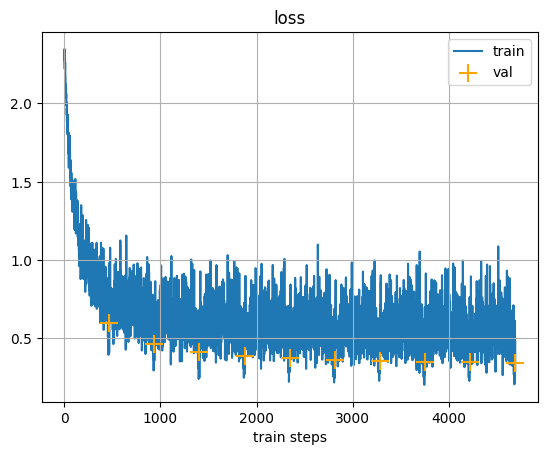

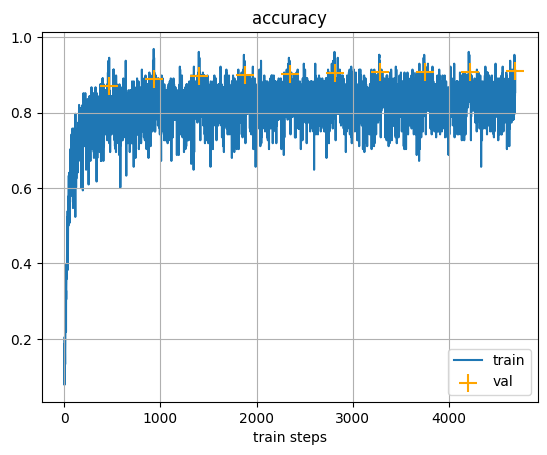

Epoch: 9, val loss: 0.34403990062920353, val accuracy: 0.9096123576164246


In [10]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
train(modelDp, opt, 10)

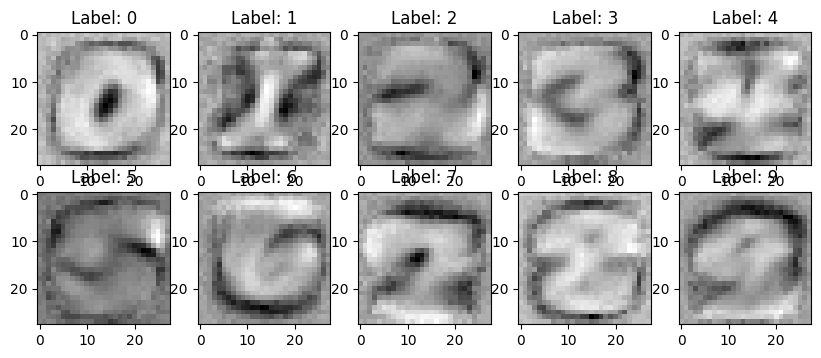

In [14]:
weights = modelDp[2].weight.data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Обучите еще одну модель, в которой вместо Dropout-регуляризации используется L2-регуляризация с коэффициентом 0.05. (Параметр weight_decay в оптимизаторе). Визуализируйте веса и сравните с двумя предыдущими подходами.

In [15]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size,num_classes),
    nn.LogSoftmax(dim=-1)
    )

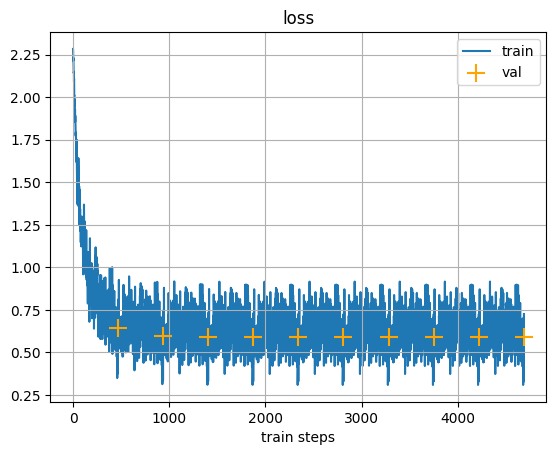

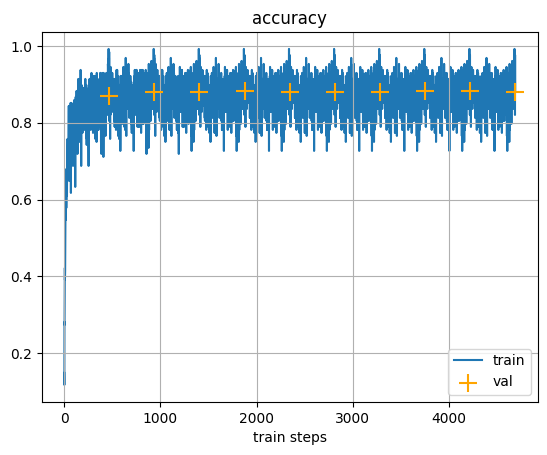

Epoch: 9, val loss: 0.5904805835666536, val accuracy: 0.8812302350997925


In [16]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05)
train(model, opt, 10)

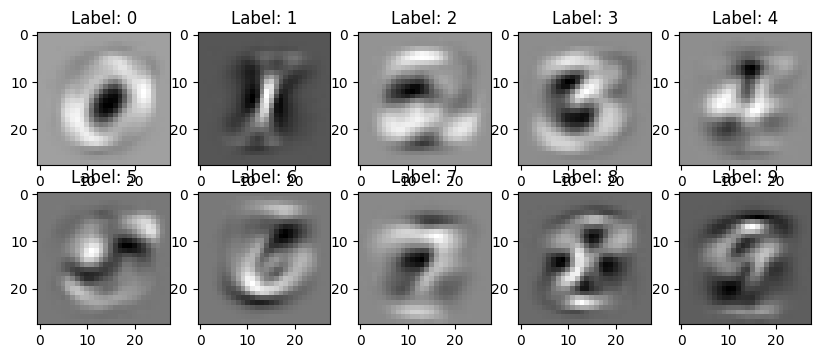

In [17]:
weights = model[1].weight.data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

## Batch normalization

Реализуйте BatchNormalization слой для полносвязной сети. В реализации достаточно только центрировать и разделить на корень из дисперсии, аффинную поправку (гамма и бета) в этом задании можно не реализовывать.

In [18]:
class BnLayer(nn.Module):
    def __init__(self, num_features, alpha=1e-1, eps=1e-5):
        super().__init__()
        self.moving_avg = torch.zeros(num_features)
        self.moving_var = torch.zeros(num_features)

        self.alpha = alpha
        self.eps = eps

    def forward(self, input):
      mu = input.mean(dim=0)
      var = input.std(dim=0)

      if self.training:
        ret = (input - mu) / (var + self.eps)
        self.moving_avg = mu.data * self.alpha + (1 - self.alpha) * self.moving_avg
        self.moving_var = var.data * self.alpha + (1 - self.alpha) * self.moving_var
      else:
        x = input - Variable(self.moving_avg, requires_grad=False)
        y = Variable(self.moving_var, requires_grad=False) + self.eps
        ret = x / y
      return ret

Обучите трехслойную полносвязную сеть (размер скрытого слоя возьмите 100) с сигмоидами в качестве функций активации.

In [22]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, num_classes),
    nn.LogSoftmax(dim=-1)
    )

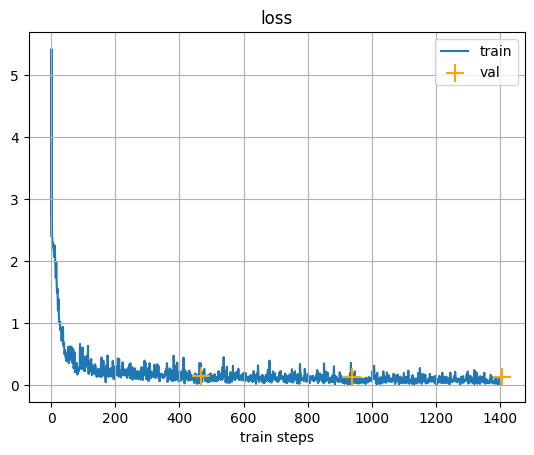

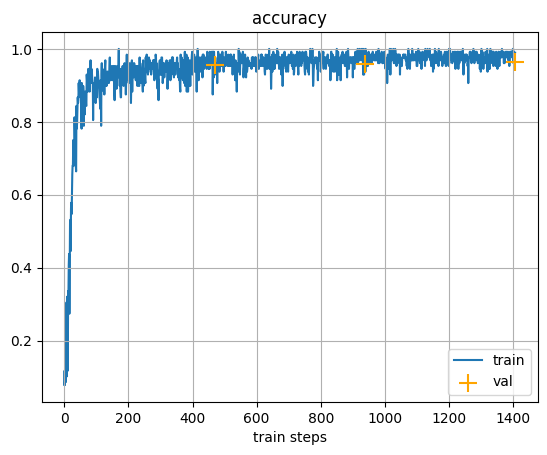

Epoch: 2, val loss: 0.12187322046713833, val accuracy: 0.9653876423835754


In [23]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)
train(model, opt, 3)

Повторите обучение с теми же параметрами для сети с той же архитектурой, но с добавлением BatchNorm слоя (для всех трех скрытых слоев).

In [25]:
modelBN = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, 100),
    BnLayer(100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    BnLayer(100),
    nn.Sigmoid(),
    nn.Linear(100, num_classes),
    nn.LogSoftmax(dim=-1)
    )

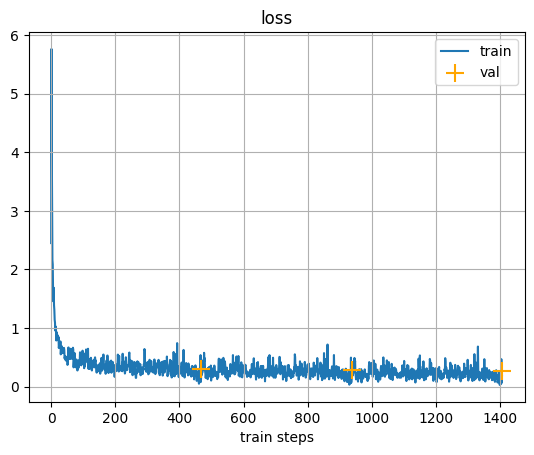

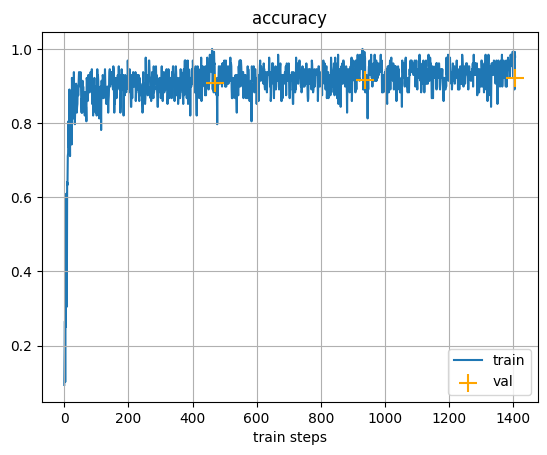

Epoch: 2, val loss: 0.25856219390053536, val accuracy: 0.921281635761261


In [26]:
opt = torch.optim.RMSprop(modelBN.parameters(), lr=0.01)
train(modelBN, opt, 3)

Сравните кривые обучения и сделайте вывод о влиянии BatchNorm на ход обучения.

In [27]:
modelBNReLU = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, 100),
    BnLayer(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    BnLayer(100),
    nn.ReLU(),
    nn.Linear(100, num_classes),
    nn.LogSoftmax(dim=-1)
    )

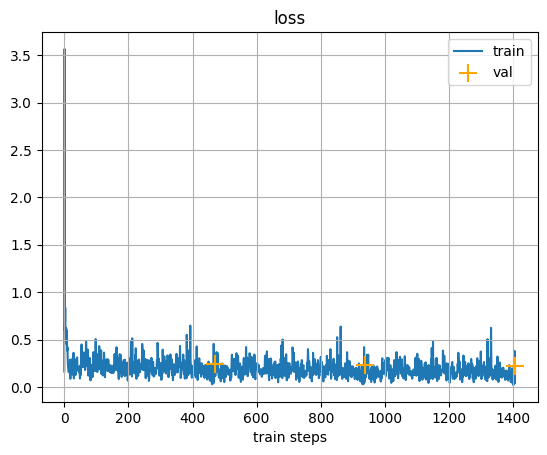

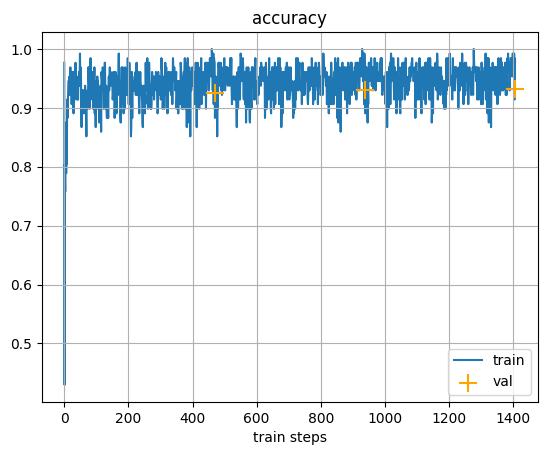

Epoch: 2, val loss: 0.2235992007735598, val accuracy: 0.9325553774833679


In [28]:
opt = torch.optim.RMSprop(modelBN.parameters(), lr=0.01)
train(modelBN, opt, 3)

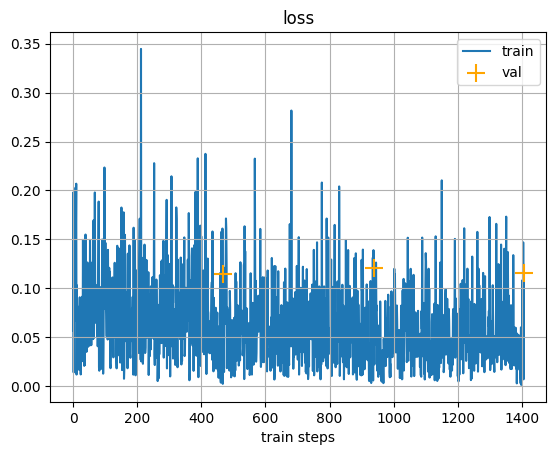

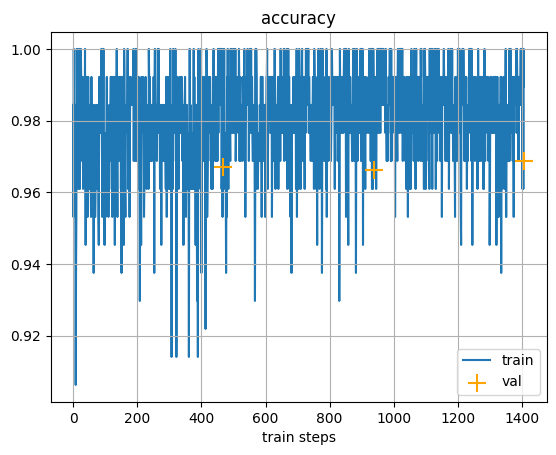

Epoch: 2, val loss: 0.11595986678288613, val accuracy: 0.96875


In [30]:
opt = torch.optim.Adam(modelBNReLU.parameters(), lr=0.01)
train(modelBNReLU, opt, 3)

Можно заметить, что BatchNorm лучше работает с ReLU, чем для сигмоиды